In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, f1_score, precision_score
import time
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble, preprocessing
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
from my_functions import *
from sklearn.utils import shuffle
from sklearn.calibration import CalibratedClassifierCV

In [2]:
train_labels = pd.read_csv('Data/bci/TrainLabels.csv')
submission = pd.read_csv('Data/bci/SampleSubmission.csv')
true_labels = pd.read_csv('Data/bci/true_labels.csv')
X_train = np.load('Data/bci/X_train_final.npy')
X_test = np.load('Data/bci/X_test_final.npy')

In [3]:
Y_train = train_labels.Prediction.values
Y_test = true_labels['1'].values

In [4]:
Y_train

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [5]:
Y_test

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [6]:
Y_train.shape

(5440,)

In [7]:
Y_test.shape

(3399,)

In [8]:
Y = np.concatenate((Y_train,Y_test))
Y.shape

(8839,)

In [9]:
X_train.shape

(5440, 210)

In [10]:
X_test.shape

(3400, 210)

In [11]:
X = np.concatenate((X_train,X_test))[:-1]

In [12]:
def RFfunc(x_train1, x_test1, y_train1, y_test1):
    clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=200, 
                                          random_state=42)
    clf.fit(x_train1, y_train1)
    probs = clf.predict_proba(x_test1)[:,1]
    f1, apr, acc, auc = matrix_info(0.6651,y_test1, probs)
    return round(f1,3), round(apr,3), round(acc,3), round(auc,3)

def MLPfunc(x_train1, x_test1, y_train1, y_test1):
    start = time.time()
    mlp = MLPClassifiermlp = MLPClassifier(solver='adam', activation='relu', alpha=0.0001, 
                                           hidden_layer_sizes = (64, 1), max_iter = 10000)
    mlp.fit(x_train1, y_train1)
    probs = mlp.predict_proba(x_test1)[:,1]
    f1, apr, acc, auc = matrix_info(0.77, y_test1, probs)
    now = time.time()
    print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
    return round(f1,3), round(apr,3), round(acc,3), round(auc,3)

def SVMfunc(x_train1, x_test1, y_train1, y_test1):
    start = time.time()
    svc = SVC(kernel = 'rbf', C = 5, degree = 10, gamma = 0.04, 
              max_iter =  100000, probability = True, n_jobs = -1)
    svc.fit(x_train1, y_train1)
    probs = svc.predict_proba(x_test1)[:,1]
    f1, apr, acc, auc = matrix_info(0.7521,y_test1, probs)
    now = time.time()
    print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
    return round(f1,3), round(apr,3), round(acc,3), round(auc,3)

def LSVMfunc(x_train1, x_test1, y_train1, y_test1):
    start=time.time()
    svc = LinearSVC(C = 5, loss = 'hinge', max_iter=10000)
    svc = CalibratedClassifierCV(svc)
    svc.fit(x_train1,y_train1)
    probs = svc.predict_proba(x_test1)[:,1]
    f1, apr, acc, auc = matrix_info(0.7521,y_test1, probs)
    now = time.time()
    print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
    return round(f1,3), round(apr,3), round(acc,3), round(auc,3)

In [84]:
rf = np.empty([9, 7])
mlp = np.empty([9, 7])
svm = np.empty([9, 7])
test_sizes = [0.2,0.5,0.8]
X_train = preprocessing.scale(X_train)
X_train,Y_train = shuffle(X_train, Y_train)
j = 0
start1 = time.time()
for size in test_sizes:
    for i in np.arange(3):
        print(size, i)
        x_train1, x_test1, y_train1, y_test1 = train_test_split(X_train, Y_train, test_size=size)
        rf_time = time.time()
        rf_f1, rf_apr, rf_acc, rf_auc = RFfunc(x_train1, x_test1, y_train1, y_test1)
        rf_time = time.time() - rf_time
        
        mlp_time = time.time()
        mlp_f1, mlp_apr, mlp_acc, mlp_auc = MLPfunc(x_train1, x_test1, y_train1, y_test1)
        mlp_time = time.time() - mlp_time
        
        svm_time = time.time()
        svm_f1, svm_apr, svm_acc, svm_auc = LSVMfunc(x_train1, x_test1, y_train1, y_test1)
        svm_time = time.time() - svm_time
        rf[j] = [rf_f1, rf_apr, rf_acc, rf_auc, i, size, rf_time]
        mlp[j] = [mlp_f1, mlp_apr, mlp_acc, mlp_auc, i, size, mlp_time]
        svm[j] = [svm_f1, svm_apr, svm_acc, svm_auc, i, size, svm_time]
        j = j + 1
now1 = time.time()
print('Elapsed Time: ' + str(int(now1-start1)) + ' seconds')

0.2 0
f1_score:
0.6524113234714373
precision_score:
0.6636478638376171
accuracy_score:
0.6700367647058824
Confusion Matrix:
[[242  74]
 [285 487]]
              precision    recall  f1-score   support

           0       0.46      0.77      0.57       316
           1       0.87      0.63      0.73       772

    accuracy                           0.67      1088
   macro avg       0.66      0.70      0.65      1088
weighted avg       0.75      0.67      0.69      1088

f1_score:
0.6520957566329617
precision_score:
0.6633568696675493
accuracy_score:
0.7279411764705882
Confusion Matrix:
[[142 174]
 [122 650]]
              precision    recall  f1-score   support

           0       0.54      0.45      0.49       316
           1       0.79      0.84      0.81       772

    accuracy                           0.73      1088
   macro avg       0.66      0.65      0.65      1088
weighted avg       0.72      0.73      0.72      1088

Elapsed Time: 12 seconds


C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.680922483259562
precision_score:
0.6825443230582483
accuracy_score:
0.703125
Confusion Matrix:
[[239  77]
 [246 526]]
              precision    recall  f1-score   support

           0       0.49      0.76      0.60       316
           1       0.87      0.68      0.77       772

    accuracy                           0.70      1088
   macro avg       0.68      0.72      0.68      1088
weighted avg       0.76      0.70      0.72      1088

Elapsed Time: 12 seconds
0.2 1
f1_score:
0.6118167546738975
precision_score:
0.6372658159109422
accuracy_score:
0.6231617647058824
Confusion Matrix:
[[246  76]
 [334 432]]
              precision    recall  f1-score   support

           0       0.42      0.76      0.55       322
           1       0.85      0.56      0.68       766

    accuracy                           0.62      1088
   macro avg       0.64      0.66      0.61      1088
weighted avg       0.72      0.62      0.64      1088

f1_score:
0.6478014022570793
precision_score

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6221373650107991
precision_score:
0.6549039461441628
accuracy_score:
0.6305147058823529
Confusion Matrix:
[[262  60]
 [342 424]]
              precision    recall  f1-score   support

           0       0.43      0.81      0.57       322
           1       0.88      0.55      0.68       766

    accuracy                           0.63      1088
   macro avg       0.65      0.68      0.62      1088
weighted avg       0.75      0.63      0.65      1088

Elapsed Time: 14 seconds
0.2 2
f1_score:
0.6854283017530507
precision_score:
0.6804671516253694
accuracy_score:
0.7150735294117647
Confusion Matrix:
[[222 108]
 [202 556]]
              precision    recall  f1-score   support

           0       0.52      0.67      0.59       330
           1       0.84      0.73      0.78       758

    accuracy                           0.72      1088
   macro avg       0.68      0.70      0.69      1088
weighted avg       0.74      0.72      0.72      1088

f1_score:
0.6485531990321969
prec

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6916073461672274
precision_score:
0.685969277329754
accuracy_score:
0.7251838235294118
Confusion Matrix:
[[215 115]
 [184 574]]
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       330
           1       0.83      0.76      0.79       758

    accuracy                           0.73      1088
   macro avg       0.69      0.70      0.69      1088
weighted avg       0.74      0.73      0.73      1088

Elapsed Time: 19 seconds
0.5 0
f1_score:
0.6543527243726239
precision_score:
0.6501316641484999
accuracy_score:
0.6922794117647059
Confusion Matrix:
[[ 491  303]
 [ 534 1392]]
              precision    recall  f1-score   support

           0       0.48      0.62      0.54       794
           1       0.82      0.72      0.77      1926

    accuracy                           0.69      2720
   macro avg       0.65      0.67      0.65      2720
weighted avg       0.72      0.69      0.70      2720

f1_score:
0.6281061356670099
p

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6428408049297456
precision_score:
0.658701632367062
accuracy_score:
0.6580882352941176
Confusion Matrix:
[[ 614  180]
 [ 750 1176]]
              precision    recall  f1-score   support

           0       0.45      0.77      0.57       794
           1       0.87      0.61      0.72      1926

    accuracy                           0.66      2720
   macro avg       0.66      0.69      0.64      2720
weighted avg       0.75      0.66      0.67      2720

Elapsed Time: 8 seconds
0.5 1
f1_score:
0.6451176552083441
precision_score:
0.6434033182541024
accuracy_score:
0.6790441176470589
Confusion Matrix:
[[ 503  277]
 [ 596 1344]]
              precision    recall  f1-score   support

           0       0.46      0.64      0.54       780
           1       0.83      0.69      0.75      1940

    accuracy                           0.68      2720
   macro avg       0.64      0.67      0.65      2720
weighted avg       0.72      0.68      0.69      2720

f1_score:
0.664626270983206

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6690615918676572
precision_score:
0.6648100080847623
accuracy_score:
0.7033088235294118
Confusion Matrix:
[[ 519  261]
 [ 546 1394]]
              precision    recall  f1-score   support

           0       0.49      0.67      0.56       780
           1       0.84      0.72      0.78      1940

    accuracy                           0.70      2720
   macro avg       0.66      0.69      0.67      2720
weighted avg       0.74      0.70      0.71      2720

Elapsed Time: 8 seconds
0.5 2
f1_score:
0.6345748736850918
precision_score:
0.6524788872974496
accuracy_score:
0.6507352941176471
Confusion Matrix:
[[ 599  178]
 [ 772 1171]]
              precision    recall  f1-score   support

           0       0.44      0.77      0.56       777
           1       0.87      0.60      0.71      1943

    accuracy                           0.65      2720
   macro avg       0.65      0.69      0.63      2720
weighted avg       0.74      0.65      0.67      2720

f1_score:
0.61302606799373

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6621038352447898
precision_score:
0.6581004309837584
accuracy_score:
0.6977941176470588
Confusion Matrix:
[[ 507  270]
 [ 552 1391]]
              precision    recall  f1-score   support

           0       0.48      0.65      0.55       777
           1       0.84      0.72      0.77      1943

    accuracy                           0.70      2720
   macro avg       0.66      0.68      0.66      2720
weighted avg       0.73      0.70      0.71      2720

Elapsed Time: 8 seconds
0.8 0
f1_score:
0.6097635867317396
precision_score:
0.6269524006639999
accuracy_score:
0.6263786764705882
Confusion Matrix:
[[ 914  358]
 [1268 1812]]
              precision    recall  f1-score   support

           0       0.42      0.72      0.53      1272
           1       0.84      0.59      0.69      3080

    accuracy                           0.63      4352
   macro avg       0.63      0.65      0.61      4352
weighted avg       0.71      0.63      0.64      4352

f1_score:
0.63506860323061

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6279687963632341
precision_score:
0.6270201097694359
accuracy_score:
0.6624540441176471
Confusion Matrix:
[[ 779  493]
 [ 976 2104]]
              precision    recall  f1-score   support

           0       0.44      0.61      0.51      1272
           1       0.81      0.68      0.74      3080

    accuracy                           0.66      4352
   macro avg       0.63      0.65      0.63      4352
weighted avg       0.70      0.66      0.68      4352

Elapsed Time: 4 seconds
0.8 1
f1_score:
0.6332878662356126
precision_score:
0.6316591999053544
accuracy_score:
0.6668198529411765
Confusion Matrix:
[[ 793  500]
 [ 950 2109]]
              precision    recall  f1-score   support

           0       0.45      0.61      0.52      1293
           1       0.81      0.69      0.74      3059

    accuracy                           0.67      4352
   macro avg       0.63      0.65      0.63      4352
weighted avg       0.70      0.67      0.68      4352

f1_score:
0.63602178426416

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6220443439955636
precision_score:
0.6209840794183403
accuracy_score:
0.6567095588235294
Confusion Matrix:
[[ 770  523]
 [ 971 2088]]
              precision    recall  f1-score   support

           0       0.44      0.60      0.51      1293
           1       0.80      0.68      0.74      3059

    accuracy                           0.66      4352
   macro avg       0.62      0.64      0.62      4352
weighted avg       0.69      0.66      0.67      4352

Elapsed Time: 5 seconds
0.8 2
f1_score:
0.6378574546022678
precision_score:
0.6355823614928319
accuracy_score:
0.6734834558823529
Confusion Matrix:
[[ 783  488]
 [ 933 2148]]
              precision    recall  f1-score   support

           0       0.46      0.62      0.52      1271
           1       0.81      0.70      0.75      3081

    accuracy                           0.67      4352
   macro avg       0.64      0.66      0.64      4352
weighted avg       0.71      0.67      0.69      4352

f1_score:
0.62095572343188

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.626992743271813
precision_score:
0.6305637750010665
accuracy_score:
0.6539522058823529
Confusion Matrix:
[[ 838  433]
 [1073 2008]]
              precision    recall  f1-score   support

           0       0.44      0.66      0.53      1271
           1       0.82      0.65      0.73      3081

    accuracy                           0.65      4352
   macro avg       0.63      0.66      0.63      4352
weighted avg       0.71      0.65      0.67      4352

Elapsed Time: 4 seconds
Elapsed Time: 175 seconds


C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [85]:
rf_df = pd.DataFrame(rf, columns = ['f1', 'apr', 'acc', 'auc', 'trial', 'test_size','time'])
mlp_df = pd.DataFrame(mlp, columns = ['f1', 'apr', 'acc', 'auc', 'trial', 'test_size','time'])
svm_df = pd.DataFrame(svm, columns = ['f1', 'apr', 'acc', 'auc', 'trial', 'test_size','time'])
rf_df['avg'] = round(rf_df.drop(['trial','test_size','time'],axis=1).mean(axis=1),3).values
mlp_df['avg'] = round(mlp_df.drop(['trial','test_size','time'],axis=1).mean(axis=1),3).values
svm_df['avg'] = round(svm_df.drop(['trial','test_size','time'],axis=1).mean(axis=1),3).values
mlp_mean = round(mlp_df.groupby('test_size').mean(),3).drop('trial', axis = 1)
rf_mean = round(rf_df.groupby('test_size').mean(),3).drop('trial', axis = 1)
svm_mean = round(svm_df.groupby('test_size').mean(),3).drop('trial', axis = 1)
rf_mean['avg'] = round(rf_mean.drop('time',axis=1).mean(axis=1),3).values
mlp_mean['avg'] = round(mlp_mean.drop('time',axis=1).mean(axis=1),3).values
svm_mean['avg'] = round(svm_mean.drop('time',axis=1).mean(axis=1),3).values

rf_mean['avg_std'] = round(rf_df.groupby('test_size').std(),3)['avg'].values
mlp_mean['avg_std'] = round(mlp_df.groupby('test_size').std(),3)['avg'].values
svm_mean['avg_std'] = round(svm_df.groupby('test_size').std(),3)['avg'].values

In [24]:
X_train.shape

(5440, 210)

In [15]:
X.shape

(8839, 210)

In [27]:
Y.shape

(8839,)

In [36]:
np.unique(Y, return_counts=True)

(array([0, 1], dtype=int64), array([2579, 6260], dtype=int64))

In [28]:
kf = KFold(n_splits=5)
rf = np.empty([5, 4])
mlp = np.empty([5, 4])
svm = np.empty([5, 4])
j = 0
for train_index, test_index in kf.split(X, Y):
    x_train = X[train_index]
    y_train = Y[train_index]
    
    x_test = X[test_index]
    y_test = Y[test_index]
        
    start = time.time()
    rf_f1, rf_apr, rf_acc, rf_auc = RFfunc(x_train, x_test, y_train, y_test)
    mlp_f1, mlp_apr, mlp_acc, mlp_auc = MLPfunc(x_train, x_test, y_train, y_test)
    svm_f1, svm_apr, svm_acc, svm_auc = LSVMfunc(x_train, x_test, y_train, y_test)
 
    now = time.time()
    print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
    rf[j] = [rf_f1, rf_apr, rf_acc, rf_auc]
    mlp[j] = [mlp_f1, mlp_apr, mlp_acc, mlp_auc]
    svm[j] = [svm_f1, svm_apr, svm_acc, svm_auc]
    j = j + 1

f1_score:
0.6109603676117981
precision_score:
0.6074508780709671
accuracy_score:
0.6719457013574661
Confusion Matrix:
[[244 223]
 [357 944]]
              precision    recall  f1-score   support

           0       0.41      0.52      0.46       467
           1       0.81      0.73      0.76      1301

    accuracy                           0.67      1768
   macro avg       0.61      0.62      0.61      1768
weighted avg       0.70      0.67      0.68      1768

f1_score:
0.5876325970159437
precision_score:
0.5870391218688432
accuracy_score:
0.6442307692307693
Confusion Matrix:
[[242 225]
 [404 897]]
              precision    recall  f1-score   support

           0       0.37      0.52      0.43       467
           1       0.80      0.69      0.74      1301

    accuracy                           0.64      1768
   macro avg       0.59      0.60      0.59      1768
weighted avg       0.69      0.64      0.66      1768

Elapsed Time: 9 seconds


C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.5566016406967047
precision_score:
0.5573149270275521
accuracy_score:
0.6210407239819005
Confusion Matrix:
[[212 255]
 [415 886]]
              precision    recall  f1-score   support

           0       0.34      0.45      0.39       467
           1       0.78      0.68      0.73      1301

    accuracy                           0.62      1768
   macro avg       0.56      0.57      0.56      1768
weighted avg       0.66      0.62      0.64      1768

Elapsed Time: 39 seconds
Elapsed Time: 55 seconds
f1_score:
0.6076721210250078
precision_score:
0.6356083544824568
accuracy_score:
0.6097285067873304
Confusion Matrix:
[[475 146]
 [544 603]]
              precision    recall  f1-score   support

           0       0.47      0.76      0.58       621
           1       0.81      0.53      0.64      1147

    accuracy                           0.61      1768
   macro avg       0.64      0.65      0.61      1768
weighted avg       0.69      0.61      0.62      1768

f1_score:
0.62

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.572817879794624
precision_score:
0.5740777666999003
accuracy_score:
0.5927601809954751
Confusion Matrix:
[[333 288]
 [432 715]]
              precision    recall  f1-score   support

           0       0.44      0.54      0.48       621
           1       0.71      0.62      0.67      1147

    accuracy                           0.59      1768
   macro avg       0.57      0.58      0.57      1768
weighted avg       0.62      0.59      0.60      1768

Elapsed Time: 34 seconds
Elapsed Time: 51 seconds
f1_score:
0.6169787414276316
precision_score:
0.62272497654615
accuracy_score:
0.6600678733031674
Confusion Matrix:
[[287 143]
 [458 880]]
              precision    recall  f1-score   support

           0       0.39      0.67      0.49       430
           1       0.86      0.66      0.75      1338

    accuracy                           0.66      1768
   macro avg       0.62      0.66      0.62      1768
weighted avg       0.74      0.66      0.68      1768

f1_score:
0.56719

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.5407143797157395
precision_score:
0.5706863633338963
accuracy_score:
0.5712669683257918
Confusion Matrix:
[[277 153]
 [605 733]]
              precision    recall  f1-score   support

           0       0.31      0.64      0.42       430
           1       0.83      0.55      0.66      1338

    accuracy                           0.57      1768
   macro avg       0.57      0.60      0.54      1768
weighted avg       0.70      0.57      0.60      1768

Elapsed Time: 42 seconds
Elapsed Time: 62 seconds
f1_score:
0.4673863192443275
precision_score:
0.6314835495232368
accuracy_score:
0.6340497737556561
Confusion Matrix:
[[  66  608]
 [  39 1055]]
              precision    recall  f1-score   support

           0       0.63      0.10      0.17       674
           1       0.63      0.96      0.77      1094

    accuracy                           0.63      1768
   macro avg       0.63      0.53      0.47      1768
weighted avg       0.63      0.63      0.54      1768

f1_score:


C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.5301009553010096
precision_score:
0.5306349734042553
accuracy_score:
0.5610859728506787
Confusion Matrix:
[[269 405]
 [371 723]]
              precision    recall  f1-score   support

           0       0.42      0.40      0.41       674
           1       0.64      0.66      0.65      1094

    accuracy                           0.56      1768
   macro avg       0.53      0.53      0.53      1768
weighted avg       0.56      0.56      0.56      1768

Elapsed Time: 38 seconds
Elapsed Time: 58 seconds
f1_score:
0.5306417338790652
precision_score:
0.5300892920795609
accuracy_score:
0.6706281833616299
Confusion Matrix:
[[ 110  277]
 [ 305 1075]]
              precision    recall  f1-score   support

           0       0.27      0.28      0.27       387
           1       0.80      0.78      0.79      1380

    accuracy                           0.67      1767
   macro avg       0.53      0.53      0.53      1767
weighted avg       0.68      0.67      0.67      1767

f1_score:


C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.18127989175754117
precision_score:
0.6096317280453258
accuracy_score:
0.22014714204867006
Confusion Matrix:
[[ 387    0]
 [1378    2]]
              precision    recall  f1-score   support

           0       0.22      1.00      0.36       387
           1       1.00      0.00      0.00      1380

    accuracy                           0.22      1767
   macro avg       0.61      0.50      0.18      1767
weighted avg       0.83      0.22      0.08      1767

Elapsed Time: 37 seconds
Elapsed Time: 53 seconds


C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [29]:
rf_stats = pd.DataFrame(rf, columns = ['f1', 'apr', 'acc', 'auc'])
mlp_stats = pd.DataFrame(mlp, columns = ['f1', 'apr', 'acc', 'auc'])
svm_stats = pd.DataFrame(svm, columns = ['f1', 'apr', 'acc', 'auc'])
rf_stats['avg'] = rf_stats.mean(axis=1).values
mlp_stats['avg'] = mlp_stats.mean(axis=1).values
svm_stats['avg'] = svm_stats.mean(axis=1).values

In [30]:
rf_stats

,f1,apr,acc,auc,avg
0,0.611,0.607,0.672,0.659,0.63725
1,0.608,0.636,0.610,0.685,0.63475
2,0.617,0.623,0.660,0.730,0.65750
3,0.467,0.631,0.634,0.520,0.56300
4,0.531,0.530,0.671,0.494,0.55650


In [31]:
rf_stats.mean()

f1     0.5668
apr    0.6054
acc    0.6494
auc    0.6176
avg    0.6098
dtype: float64

In [32]:
mlp_stats

,f1,apr,acc,auc,avg
0,0.588,0.587,0.644,0.613,0.60800
1,0.630,0.678,0.704,0.631,0.66075
2,0.567,0.589,0.602,0.661,0.60475
3,0.519,0.536,0.588,0.516,0.53975
4,0.523,0.524,0.684,0.512,0.56075


In [33]:
mlp_stats.mean()

f1     0.5654
apr    0.5828
acc    0.6444
auc    0.5866
avg    0.5948
dtype: float64

In [34]:
svm_stats

,f1,apr,acc,auc,avg
0,0.557,0.557,0.621,0.584,0.57975
1,0.573,0.574,0.593,0.611,0.58775
2,0.541,0.571,0.571,0.624,0.57675
3,0.530,0.531,0.561,0.533,0.53875
4,0.181,0.610,0.220,0.477,0.37200


In [35]:
svm_stats.mean()

f1     0.4764
apr    0.5686
acc    0.5132
auc    0.5658
avg    0.5310
dtype: float64

In [86]:
rf_mean

,f1,apr,acc,auc,time,avg,avg_std
test_size,,,,,,,
0.2,0.650,0.660,0.669,0.745,4.462,0.681,0.031
0.5,0.645,0.648,0.674,0.737,2.710,0.676,0.006
0.8,0.627,0.632,0.655,0.708,1.005,0.655,0.011


In [87]:
mlp_mean

,f1,apr,acc,auc,time,avg,avg_std
test_size,,,,,,,
0.2,0.650,0.654,0.692,0.706,9.207,0.675,0.002
0.5,0.635,0.648,0.659,0.732,7.335,0.669,0.022
0.8,0.631,0.633,0.666,0.685,5.250,0.654,0.002


In [88]:
svm_mean

,f1,apr,acc,auc,time,avg,avg_std
test_size,,,,,,,
0.2,0.665,0.675,0.686,0.773,15.604,0.700,0.030
0.5,0.658,0.661,0.686,0.754,8.307,0.690,0.010
0.8,0.626,0.626,0.658,0.700,4.571,0.653,0.005


In [70]:
X_train = preprocessing.scale(X_train)
X_train,Y_train = shuffle(X_train, Y_train)
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_train, Y_train, test_size=0.2)

In [43]:
np.unique(Y_train, return_counts = True)

(array([0, 1], dtype=int64), array([2579, 6260], dtype=int64))

In [71]:
start = time.time()
clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=150, random_state=42)
clf.fit(x_train1, y_train1)

now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
probs = clf.predict_proba(x_test1)[:,1]

Elapsed Time: 1 seconds


max(tpr - fpr) w/ th =  0.6733333333333333


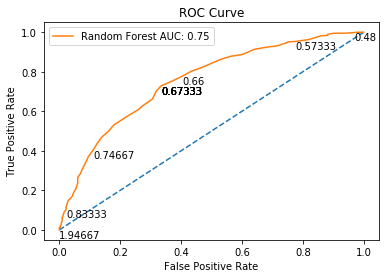

In [72]:
plot_roc(y_test1, probs, 'Random Forest')

In [80]:
start = time.time()
mlp = MLPClassifier(solver='adam', activation='relu', alpha=0.0001, hidden_layer_sizes = (64, 1), max_iter = 10000)
mlp.fit(x_train1, y_train1)

now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
probs_nn = mlp.predict_proba(x_test1)[:,1]

Elapsed Time: 8 seconds


max(tpr - fpr) w/ th =  0.9981069845990855


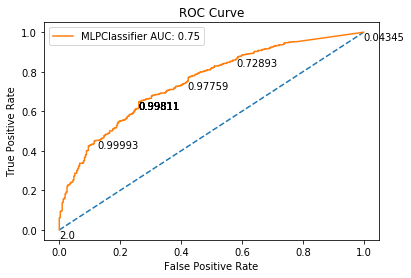

f1_score:
0.6532798484755735
precision_score:
0.6599532507066753
accuracy_score:
0.6746323529411765
Confusion Matrix:
[[232  82]
 [272 502]]
              precision    recall  f1-score   support

           0       0.46      0.74      0.57       314
           1       0.86      0.65      0.74       774

    accuracy                           0.67      1088
   macro avg       0.66      0.69      0.65      1088
weighted avg       0.74      0.67      0.69      1088



(0.6532798484755735,
 0.6599532507066753,
 0.6746323529411765,
 0.7490351223687025)

In [81]:
plot_roc(y_test1, probs_nn, 'MLPClassifier')

matrix_info(0.53, y_test1, probs_nn)

In [75]:
start = time.time()
svc = LinearSVC(C = 5, loss = 'hinge', max_iter=10000)
svc = CalibratedClassifierCV(svc)
svc.fit(x_train1,y_train1)
now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

probs_svm = svc.predict_proba(x_test1)[:,1]
#probs_svm = svc.predict(x_test1)

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Elapsed Time: 11 seconds


C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


max(tpr - fpr) w/ th =  0.7193137849669783


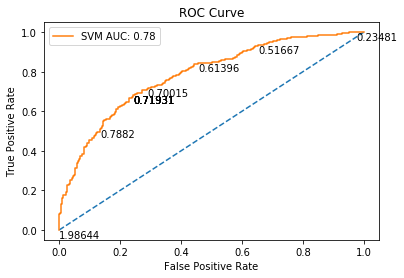

f1_score:
0.6822311368866025
precision_score:
0.683566894238831
accuracy_score:
0.7049632352941176
Confusion Matrix:
[[238  76]
 [245 529]]
              precision    recall  f1-score   support

           0       0.49      0.76      0.60       314
           1       0.87      0.68      0.77       774

    accuracy                           0.70      1088
   macro avg       0.68      0.72      0.68      1088
weighted avg       0.76      0.70      0.72      1088



(0.6822311368866025, 0.683566894238831, 0.7049632352941176, 0.7829909972185192)

In [76]:
plot_roc(y_test1, probs_svm, 'SVM')

matrix_info(0.4135, y_test1, probs_svm)

In [67]:
params = {
    'C': [1,3,5],
    'loss':['hinge','squared_hinge'],
    'max_iter': [10000]
}

svc = LinearSVC(max_iter=10000)
cv = GridSearchCV(svc, param_grid=params, scoring='accuracy', n_jobs=-1, verbose=20, refit='accuracy', cv=5)
cv.fit(x_train1,y_train1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=10000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 3, 5], 'loss': ['hinge', 'squared_hinge'],
                         'max_iter': [10000]},
             pre_dispatch='2*n_jobs', refit='accuracy',
             return_train_score=False, scoring='accuracy', verbose=20)

In [69]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][1])
cv_results.sort_values('rank_test_score')

best params:  {'C': 5, 'loss': 'hinge', 'max_iter': 10000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_loss,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,59.361901,0.832500,0.001197,0.000978,3,squared_hinge,10000,"{'C': 3, 'loss': 'squared_hinge', 'max_iter': ...",0.739380,0.737084,0.765517,0.739080,0.755172,0.747243,0.011211,1
4,10.138992,0.213413,0.005599,0.002582,5,hinge,10000,"{'C': 5, 'loss': 'hinge', 'max_iter': 10000}",0.739380,0.746269,0.756322,0.744828,0.749425,0.747243,0.005582,1
5,42.481627,5.296950,0.001404,0.000484,5,squared_hinge,10000,"{'C': 5, 'loss': 'squared_hinge', 'max_iter': ...",0.739380,0.738232,0.764368,0.739080,0.755172,0.747243,0.010637,1
1,32.855332,8.214355,0.001523,0.000774,1,squared_hinge,10000,"{'C': 1, 'loss': 'squared_hinge', 'max_iter': ...",0.739380,0.738232,0.763218,0.739080,0.755172,0.747013,0.010270,4
2,7.680700,0.599281,0.002821,0.002653,3,hinge,10000,"{'C': 3, 'loss': 'hinge', 'max_iter': 10000}",0.743972,0.743972,0.754023,0.745977,0.745977,0.746783,0.003728,5
0,3.468918,0.170807,0.001398,0.000488,1,hinge,10000,"{'C': 1, 'loss': 'hinge', 'max_iter': 10000}",0.740528,0.743972,0.755172,0.744828,0.743678,0.745634,0.004985,6


In [77]:
parameters = {'solver': ['adam','lbfgs'], 
              'activation': ['relu'],
              'max_iter': [10000], 
              'alpha': 10.0 ** -np.arange(1, 5), 
              'hidden_layer_sizes':[(10,1),(16,16),(10,10),(64,1),(64,64),(32,32),(32,16)]}
cv = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv = 5, verbose = 20)
cv.fit(x_train1,y_train1)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  2.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  5.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'alpha': array([0.1   , 0.01  , 0.001 , 0.0001]),
                         'h

In [79]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 1), 'max_iter': 10000, 'solver': 'adam'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
48,25.687581,4.223082,0.007302,3.660675e-03,relu,0.0001,"(64, 1)",10000,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.728211,0.724138,0.729885,0.731034,0.732184,0.729090,0.002802,1
8,21.868452,1.776571,0.007581,7.967244e-04,relu,0.1,"(64, 64)",10000,adam,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",0.707569,0.734483,0.719540,0.729885,0.740230,0.726333,0.011584,2
20,18.713199,4.808166,0.007381,1.954627e-03,relu,0.01,"(64, 1)",10000,adam,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.731651,0.727586,0.700000,0.732184,0.733333,0.724954,0.012623,3
6,26.303027,7.800243,0.005786,3.990414e-04,relu,0.1,"(64, 1)",10000,adam,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",0.735092,0.726437,0.709195,0.727586,0.726437,0.724954,0.008515,3
15,2.483259,0.713659,0.002793,3.992568e-04,relu,0.01,"(10, 1)",10000,lbfgs,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.732798,0.739080,0.686207,0.706897,0.737931,0.720588,0.020788,5
9,3.374847,0.276855,0.008178,3.990653e-04,relu,0.1,"(64, 64)",10000,lbfgs,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",0.713303,0.720690,0.706897,0.731034,0.725287,0.719439,0.008545,6
34,24.382633,8.476643,0.006584,1.354829e-03,relu,0.001,"(64, 1)",10000,adam,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.702982,0.728736,0.698851,0.728736,0.735632,0.718980,0.015026,7
22,8.117996,0.607840,0.009974,3.025196e-03,relu,0.01,"(64, 64)",10000,adam,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.705275,0.703448,0.722989,0.729885,0.712644,0.714844,0.010186,8
50,9.035406,0.570909,0.007978,1.092016e-03,relu,0.0001,"(64, 64)",10000,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.709862,0.708046,0.702299,0.716092,0.729885,0.713235,0.009414,9
14,11.309465,1.736745,0.003790,2.630431e-03,relu,0.01,"(10, 1)",10000,adam,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.706422,0.685057,0.714943,0.712644,0.732184,0.710248,0.015216,10
